### *Localisation optimale des capacités de production éoliennes en Europe*

Notebook pour le  chargement des données du projet (partie I) -- version 1.2 (màj le 31/3/2020)

In [2]:
## imports classiques
import numpy as np

from cylp.cy import CyClpSimplex
from cylp.py.modeling.CyLPModel import CyLPArray, CyLPModel

import matplotlib.pyplot as plt
import math 
import pandas as pd
import plotly.graph_objects as go
import matplotlib.colors as colors
import random


colors_list = list(colors._colors_full_map.values())
random.shuffle(colors_list)

%matplotlib notebook

In [3]:
## paramètres

liste_pays = ['Allemagne','Autriche','Belgique','Danemark','Espagne','France','Irlande','Italie','Luxembourg',\
             'Norvège','Pays-Bas','Portugal','Royaume-Uni','Suède','Suisse']

liste_pays_index_dic = {'Allemagne':0,'Autriche':1,'Belgique':2,'Danemark':3,'Espagne':4,'France':5,'Irlande':6,'Italie':7,'Luxembourg':8,\
             'Norvège':9,'Pays-Bas':10,'Portugal':11,'Royaume-Uni':12,'Suède':13,'Suisse':14}

list_colors_dic = {'Allemagne':colors_list[0],'Autriche':colors_list[1],'Belgique':colors_list[2],'Danemark':colors_list[3],'Espagne':colors_list[4],\
                         'France':colors_list[5],'Irlande':colors_list[6],'Italie':colors_list[7],'Luxembourg':colors_list[8],\
             'Norvège':colors_list[9],'Pays-Bas':colors_list[10],'Portugal':colors_list[11],'Royaume-Uni':colors_list[12],'Suède':colors_list[13],'Suisse':colors_list[14]} 

TURB = np.array([8587 , 12009 , 1417 , 9 , 18372 , 25132 , 527 , 21117 , 1140 , 28941 , 37 , 5052 , 4269 , 16637 , 15101])
POMP = np.array([5223 , 3580 , 1307 , 0 , 5347 , 4303 , 292 , 7544 , 1100 , 1396 , 0 , 1029 , 2744 , 45 , 1636 ])
RES = np.array([0.3*1e6 , 3.2*1e6 , 0.01*1e6 , 0 , 18.4*1e6 , 9.8*1e6 , 0.24*1e6 , 7.9*1e6 , 0.005*1e6 , 84.147*1e6 , 0 , 2.6*1e6 , 1.2*1e6 , 33.756*1e6 , 8.4*1e6])

N_pays = 15                  # plus petit ou égal à N_pays_max = 15
N_sites = 642                # plus petit ou égal à sites_max = 642
N_heures_par_annee = 24*365  # nombre d'heures par année
N_annees = 1/12                # fraction de l'annee à utiliser ; prendre par exemple 1/12 pour tester sur un mois (calculs 
                             # plus rapides) ; dans le rapport il faut utiliser l'année complète N_annees = 1
N_heures = int(np.ceil(N_heures_par_annee*N_annees)) # nombre d'heures à extraire des fichiers de rendements

vecteur_temps = np.arange(1,N_heures+1) / N_heures_par_annee

In [4]:
## chargement et traitement des données brutes (I)
 
sites = pd.read_csv('Sites.csv')

onshore = sites[sites['capacite offshore']=='Non'].copy()
offshore = sites[sites['capacite offshore']=='Oui'].copy()

In [5]:
sites.head()

,index site,latitude,longitude,pays,couleur,capacite offshore,scores,capacites
0,1,54.0,8.0,Allemagne,#7b0323,Non,0.003291,7509.607003
1,2,54.0,9.0,Allemagne,#7b0323,Non,0.002193,5003.709632
2,3,54.0,10.0,Allemagne,#7b0323,Non,0.001852,4225.781588
3,4,54.0,11.0,Allemagne,#7b0323,Non,0.001852,4225.781588
4,5,54.0,12.0,Allemagne,#7b0323,Non,0.002193,5003.709632


In [6]:
onshore.head()

,index site,latitude,longitude,pays,couleur,capacite offshore,scores,capacites
0,1,54.0,8.0,Allemagne,#7b0323,Non,0.003291,7509.607003
1,2,54.0,9.0,Allemagne,#7b0323,Non,0.002193,5003.709632
2,3,54.0,10.0,Allemagne,#7b0323,Non,0.001852,4225.781588
3,4,54.0,11.0,Allemagne,#7b0323,Non,0.001852,4225.781588
4,5,54.0,12.0,Allemagne,#7b0323,Non,0.002193,5003.709632


In [7]:
offshore.head()

,index site,latitude,longitude,pays,couleur,capacite offshore,scores,capacites
487,0,54.0,7.0,Allemagne,#7b0323,Oui,0.006342,8364.150000
488,48,56.0,5.0,Danemark,#A9A9A9,Oui,0.010571,15478.589744
489,49,55.0,6.0,Allemagne,#7b0323,Oui,0.010571,13940.250000
490,61,52.0,3.0,Pays-Bas,#04d8b2,Oui,0.006342,2349.264706
491,66,58.0,10.0,Suède,#758da3,Oui,0.006342,8577.125000


In [8]:
p= 3*np.ones(2)
n = np.array([[1,1],[2,2]])
print((np.dot(n,p)).sum())

18.0


In [9]:
"""# Visualisations des données pour les sites 

fig = go.Figure(data=go.Scattergeo(
        lon = offshore['longitude'],
        lat = offshore['latitude'],
        text = offshore['pays'],
        mode = 'markers',
        marker=dict(
        color = offshore['couleur'],
        size = offshore['scores']*1000)
        ))

fig.update_layout(
        title = 'Sites offshore, et leur importance',
        geo_scope = 'europe'
    )
fig.show();"""

"# Visualisations des données pour les sites \n\nfig = go.Figure(data=go.Scattergeo(\n        lon = offshore['longitude'],\n        lat = offshore['latitude'],\n        text = offshore['pays'],\n        mode = 'markers',\n        marker=dict(\n        color = offshore['couleur'],\n        size = offshore['scores']*1000)\n        ))\n\nfig.update_layout(\n        title = 'Sites offshore, et leur importance',\n        geo_scope = 'europe'\n    )\nfig.show();"

In [10]:
"""fig = go.Figure(data=go.Scattergeo(
        lon = onshore['longitude'],
        lat = onshore['latitude'],
        text = onshore['pays'],
        mode = 'markers',
        marker=dict(
        color = onshore['couleur'],
        size = onshore['scores']*3000)
        ))

fig.update_layout(
        title = 'Sites onshore, et leur importance',
        geo_scope = 'europe'
    )
fig.show();"""

"fig = go.Figure(data=go.Scattergeo(\n        lon = onshore['longitude'],\n        lat = onshore['latitude'],\n        text = onshore['pays'],\n        mode = 'markers',\n        marker=dict(\n        color = onshore['couleur'],\n        size = onshore['scores']*3000)\n        ))\n\nfig.update_layout(\n        title = 'Sites onshore, et leur importance',\n        geo_scope = 'europe'\n    )\nfig.show();"

In [11]:
"""fig = go.Figure(data=go.Scattergeo(
        lon = sites['longitude'],
        lat = sites['latitude'],
        text = sites['pays'],
        mode = 'markers',
        marker_color = sites['couleur'],
        marker = dict(size = 2),
        ))

fig.update_layout(
        title = 'Affectation par pays des sites éoliens',
        geo_scope = 'europe'
    )
fig.show();"""

"fig = go.Figure(data=go.Scattergeo(\n        lon = sites['longitude'],\n        lat = sites['latitude'],\n        text = sites['pays'],\n        mode = 'markers',\n        marker_color = sites['couleur'],\n        marker = dict(size = 2),\n        ))\n\nfig.update_layout(\n        title = 'Affectation par pays des sites éoliens',\n        geo_scope = 'europe'\n    )\nfig.show();"

In [12]:
"""fig = go.Figure(data=go.Scattergeo(
        lon = sites['longitude'],
        lat = sites['latitude'],
        text = 'pays: '+sites['pays']+', offshore: '+sites['capacite offshore']+' | capacite [MW] = '+\
        sites['capacites'].astype(str),
        mode = 'markers',
        marker = dict(
            color = sites['couleur'],
            size = sites['capacites']/sites['capacites'].max() * 30)
        ))

fig.update_layout(
        title = 'Capacites des sites éoliens',
        geo_scope = 'europe'
    )
fig.show();"""

"fig = go.Figure(data=go.Scattergeo(\n        lon = sites['longitude'],\n        lat = sites['latitude'],\n        text = 'pays: '+sites['pays']+', offshore: '+sites['capacite offshore']+' | capacite [MW] = '+        sites['capacites'].astype(str),\n        mode = 'markers',\n        marker = dict(\n            color = sites['couleur'],\n            size = sites['capacites']/sites['capacites'].max() * 30)\n        ))\n\nfig.update_layout(\n        title = 'Capacites des sites éoliens',\n        geo_scope = 'europe'\n    )\nfig.show();"

In [13]:
"""## chargement et traitement des données brutes (II)
matrice_rendements_offshore = np.genfromtxt('Rendements_offshore.csv', delimiter=',')[:,:N_heures]
matrice_rendements_onshore = np.genfromtxt('Rendements_onshore.csv', delimiter=',')[:,:N_heures]
print(matrice_rendements_onshore.shape)
print(matrice_rendements_offshore.shape)"""

"## chargement et traitement des données brutes (II)\nmatrice_rendements_offshore = np.genfromtxt('Rendements_offshore.csv', delimiter=',')[:,:N_heures]\nmatrice_rendements_onshore = np.genfromtxt('Rendements_onshore.csv', delimiter=',')[:,:N_heures]\nprint(matrice_rendements_onshore.shape)\nprint(matrice_rendements_offshore.shape)"

In [20]:
# Exemple CyLP

s = CyClpSimplex()

# Add variables
x = s.addVariable('x', 4)

# Create coefficients and bounds
A = np.matrix([[0.5, -5.5, -2.5, 9],[0.5, -1.5, -0.5, 1]])
#B = np.matrix([[1., 0, 0], [0, 0, 1.]])
#D = np.matrix([[1., 2.],[0, 1]])
a = CyLPArray([0, 0])
#b = CyLPArray([4.2, 3])
x_u= CyLPArray([1])

# Add constraints
s += A * x <= a
#s += 2 <= B * x + D * y <= b
#s += y >= 0
s += 0 <= x[0] <= x_u
s += 0 <= x[1:4]

# Set the objective function
c = -CyLPArray([10, -57, -9, -24])
s.objective = c * x 

# Solve using primal Simplex
s.primal()
print (s.primalVariableSolution['x'])
print(s.getStatusString())

[1. 0. 1. 0.]
optimal


In [17]:
#version un peu stylé, mais pas trop

s = CyClpSimplex()

N = 4 # nombre de sites
H = 10 # heures
T = 2 # pas de temps
offshore = 2  # index à partir duquel on commence à avoir des offshore
kappa = 0.17


# Add variables
x = s.addVariable('x', N)

# Create coefficients and bounds
#p = CyLPArray([100])
p=100


# Add constraints
s += CyLPArray(np.ones(N))*x == p

offshorearray = np.zeros(N)
offshorearray[offshore:] = 1
s += CyLPArray(offshorearray)*x == kappa*p

print ("\nConstraints :\n", s.constraints)
print ("\nConstraintMatrix :\n", s.coefMatrix)

# Set the objective function
#c= -CyLPArray([ i%2 for i in range(N)])
rend = np.array([[i/(j+40) for j in range(H)] for i in range(N)])
rend_array = np.array([np.sum(rend[i]) for i in range(N)])
c= -CyLPArray(rend_array)
s.objective = c * x
print("\nc = ",s.objective)

# Solve using primal Simplex
s.primal()

print ("\nsol = ",s.primalVariableSolution['x'])
print("\nObjVal = ", -s.objectiveValue)
print("\nSOL OPTIMALE ? = ", s.getStatusString())


Constraints :
 [
constraint R_11:
variable names:
['x']
coefficients:
{x: CyLPArray([1., 1., 1., 1.])}
lower = [100.]
upper = [100.]
normal Constarint
, 
constraint R_12:
variable names:
['x']
coefficients:
{x: CyLPArray([0., 0., 1., 1.])}
lower = [17.]
upper = [17.]
normal Constarint
]

ConstraintMatrix :
   (0, 0)	1.0
  (0, 1)	1.0
  (0, 2)	1.0
  (1, 2)	1.0
  (0, 3)	1.0
  (1, 3)	1.0

c =  [ 0.        -0.2256623 -0.4513246 -0.6769869]

sol =  [ 0. 83.  0. 17.]

ObjVal =  30.238748118668575

SOL OPTIMALE ? =  dual infeasible


In [25]:
n = np.array([[1,1,3],
              [2,3,6]])
array = np.array([np.sum(n[i]) for i in range(2)])
print(array)

[ 5 11]


In [15]:
#Version merdique

"""#Données

PP = CyLPArray([2])
P = CyLPArray([1]) # puissance totale voulue
N = 3                     # nombre de sites
H = 10                    # nombres d'heures condidérées
k = 0.17                  # ratio de offshore


s = CyClpSimplex()

# Add variables
x = s.addVariable('x',N)

n= CyLPArray(np.transpose(np.array( [[random.random() for i in range(H)] for j in range(N)]  ))) 
#n= CyLPArray(np.transpose(np.zeros((N,H)) )) #rendements fictis


# Add constraints
s += np.sum(x*np.ones(N)) >=  P
s += np.sum(x*np.ones(N)) <=  PP

#s += x[2:]*np.ones(3-2+1) <= k*P
#s += x[2:]*np.ones(3-2+1) >= k*P


# Set the objective function
s.objective = -(x*n)
#s.objective = x




# Solve using primal Simplex
s.primal()
print( s.primalVariableSolution['x'])"""

"#Données\n\nPP = CyLPArray([2])\nP = CyLPArray([1]) # puissance totale voulue\nN = 3                     # nombre de sites\nH = 10                    # nombres d'heures condidérées\nk = 0.17                  # ratio de offshore\n\n\ns = CyClpSimplex()\n\n# Add variables\nx = s.addVariable('x',N)\n\nn= CyLPArray(np.transpose(np.array( [[random.random() for i in range(H)] for j in range(N)]  ))) \n#n= CyLPArray(np.transpose(np.zeros((N,H)) )) #rendements fictis\n\n\n# Add constraints\ns += np.sum(x*np.ones(N)) >=  P\ns += np.sum(x*np.ones(N)) <=  PP\n\n#s += x[2:]*np.ones(3-2+1) <= k*P\n#s += x[2:]*np.ones(3-2+1) >= k*P\n\n\n# Set the objective function\ns.objective = -(x*n)\n#s.objective = x\n\n\n\n\n# Solve using primal Simplex\ns.primal()\nprint( s.primalVariableSolution['x'])"

In [16]:
print(np.sum(CyLPArray(np.array([1,2,3]))*np.array([1,1,1])))

a = np.ones((3,3))
b = np.array([1,2,3])

print(b*a)


6
[[1. 2. 3.]
 [1. 2. 3.]
 [1. 2. 3.]]


il y a 80 sites éoliens en France


NameError: name 'matrice_rendements_onshore' is not defined

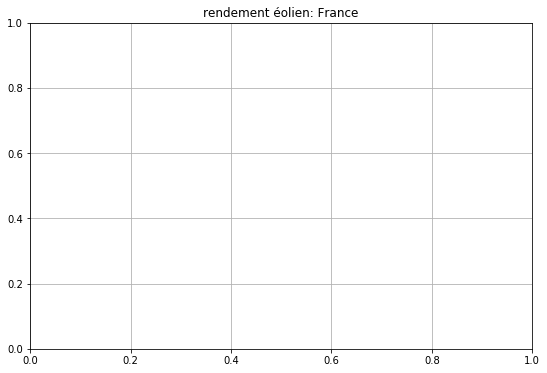

In [17]:
## Visualisation des rendements pour un pays

pays_test = 'France'
index_test = liste_pays_index_dic[pays_test]

# nombre de sites éoliens
index_sites_eoliens = sites[sites.pays==pays_test]['index site']
n_eoliens = len(index_sites_eoliens)
print('il y a '+str(n_eoliens)+' sites éoliens en '+str(pays_test))

# rendements eolien au hasard
random_site = np.random.choice(index_sites_eoliens)
plt.figure(figsize=(9,6))
plt.grid()
plt.title('rendement éolien: '+str(pays_test))
if sites.loc[random_site]['capacite offshore']=='Oui':
    plt.plot(vecteur_temps,matrice_rendements_offshore[random_site])
    plt.legend(['offshore'])
else:
    plt.plot(vecteur_temps,matrice_rendements_onshore[random_site])
    plt.legend(['onshore'])
plt.xlabel('temps : [années]')
plt.ylabel('rendement éolien: [/]')

print('rendement moyen offshore pour le pays: '+str(np.mean(matrice_rendements_offshore[index_sites_eoliens])))
print('rendement moyen onshore pour le pays: '+str(np.mean(matrice_rendements_onshore[index_sites_eoliens])))

# capacité éoliennes maximales tolérables
buf_ok_offshore = (sites.pays==pays_test) & (sites['capacite offshore']=='Oui')
buf_ok_onshore = (sites.pays==pays_test) & (sites['capacite offshore']=='Non')

print(' => capacité éolienne totale offshore : [MW] '+str(sites[buf_ok_offshore]['capacites'].sum()))
print(' => capacité éolienne totale offshore : [MW] '+str(sites[buf_ok_onshore]['capacites'].sum()))

# latitude/longitude
print('le pays '+str(pays_test)+' se trouve  à une latitude de '+str(sites.loc[random_site]['latitude'])+' et une longitude de '+\
      str(sites.loc[random_site]['longitude']))